In [1]:
import numpy as np
from chmm_actions import CHMM, forwardE, datagen_structured_obs_room
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os, sys, pickle

retrain_models = False

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")

In [2]:
def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out


def get_mess_fwd(chmm, x, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    T = T.mean(0, keepdims=True)
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, x * 0, store_messages=True
    )
    return mess_fwd


def place_field(mess_fwd, rc, clone):
    assert mess_fwd.shape[0] == rc.shape[0] and clone < mess_fwd.shape[1]
    field = np.zeros(rc.max(0) + 1)
    count = np.zeros(rc.max(0) + 1, int)
    for t in range(mess_fwd.shape[0]):
        r, c = rc[t]
        field[r, c] += mess_fwd[t, clone]
        count[r, c] += 1
    count[count == 0] = 1
    return field / count


# Training a CHMM

In [3]:
# Train CHMM on random data
TIMESTEPS = 1000
OBS = 2
x = np.random.randint(OBS, size=(1000,), dtype=np.int64)  # Observations. Replace with your data.
a = np.zeros(
    1000, dtype=np.int64
)  # If there are actions in your domain replace this. If not, keep the vector of zeros.
n_clones = (
    np.ones(OBS, dtype=np.int64) * 5
)  # Number of clones specifies the capacity for each observation.

x_test = np.random.randint(
    OBS, size=(1000,), dtype=np.int64
)  # Test observations. Replace with your data.
a_test = np.zeros(1000, dtype=np.int64)

name = 'intro-random_data'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)

else:
    chmm = CHMM(n_clones=n_clones, pseudocount=1e-10, x=x, a=a)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=100, term_early=False)  # Training
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object


nll_per_prediction = chmm.bps(
    x_test, a_test
)  # Evaluate negative log-likelihood (base 2 log)
avg_nll = np.mean(nll_per_prediction)
avg_prediction_probability = 2 ** (-avg_nll)
print(avg_prediction_probability)


0.4942123


# Rectangular room datagen

In [4]:
room = np.array(
    [
        [1, 2, 3, 0, 3, 1, 1, 1],
        [1, 1, 3, 2, 3, 2, 3, 1],
        [1, 1, 2, 0, 1, 2, 1, 0],
        [0, 2, 1, 1, 3, 0, 0, 2],
        [3, 3, 1, 0, 1, 0, 3, 0],
        [2, 1, 2, 3, 3, 3, 2, 0],
    ]
)

# room = np.array(
#     [
#         [1, 2, 3, 0, 3,],
#         [1, 1, 3, 2, 3,],
#         [1, 1, 2, 0, 1,],
#         [0, 2, 1, 1, 3,],
#         [3, 3, 1, 0, 1,],
#         [2, 1, 2, 3, 3,],
#     ]
# ) use 5000, 100

n_emissions = room.max() + 1

a, x, rc = datagen_structured_obs_room(room, length=50000)
print(rc.shape)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70

name = 'intro-rectangular_room'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)
else:
    chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object



(50000, 2)


In [5]:
# refine learning
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:03<02:43,  1.67s/it, train_bps=0.000163]


[np.float32(0.007812547), np.float32(0.00016258565), np.float32(0.00016258565)]

(4, 280, 280)
(4, 280, 280)
(280, 280)


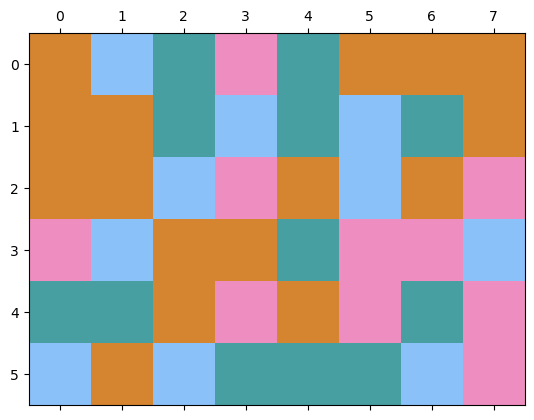

In [6]:
print(chmm.C.shape)
print(chmm.T.shape)
print(chmm.T[0].shape)

cmap = colors.ListedColormap(custom_colors[-4:])
plt.matshow(room, cmap=cmap)
plt.savefig("figures/rectangular_room_layout.pdf")


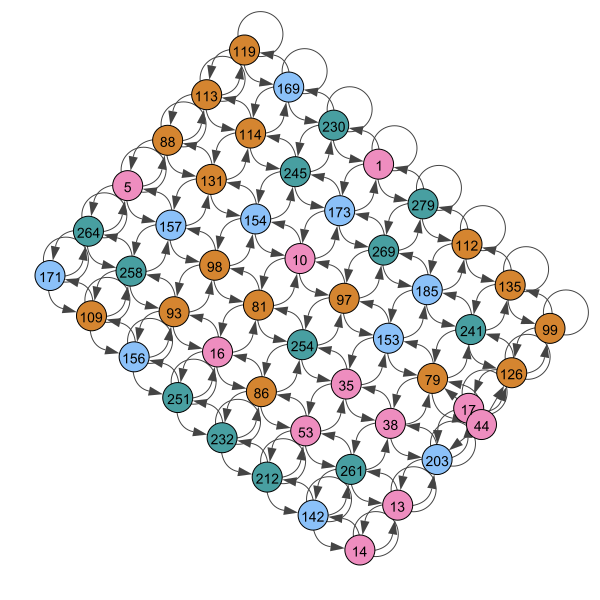

In [7]:
graph = plot_graph(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf", cmap=cmap
)
graph


In [8]:
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=0.1)


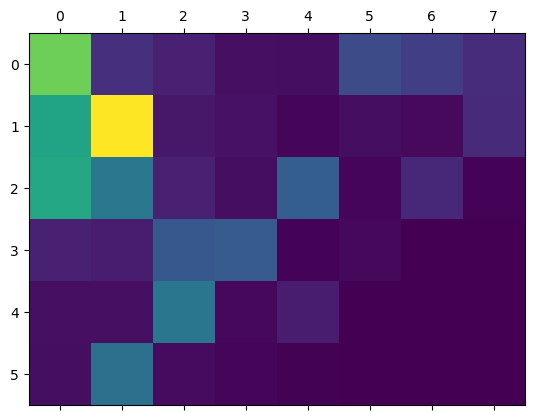

In [9]:
clone = 114
plt.matshow(place_field(mess_fwd, rc, clone))
plt.savefig("figures/rectangular_room_place_field.pdf")

# Empty rectangular room datagen

In [10]:
H, W = 6, 8
room = np.zeros((H, W), dtype=np.int64)
room[:] = 0
room[0] = 5
room[-1] = 6
room[:, 0] = 7
room[:, -1] = 8
room[0, 0] = 1
room[0, -1] = 2
room[-1, 0] = 3
room[-1, -1] = 4
n_emissions = room.max() + 1

a, x, rc = datagen_structured_obs_room(room, length=50000)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70

name = 'intro-empty_rectangular_room'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)
else:
    chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=4)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training    
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object


In [11]:
# refine learning
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it, train_bps=0.000186]


[np.float32(0.0071397107),
 np.float32(0.00018598416),
 np.float32(0.00018598416)]

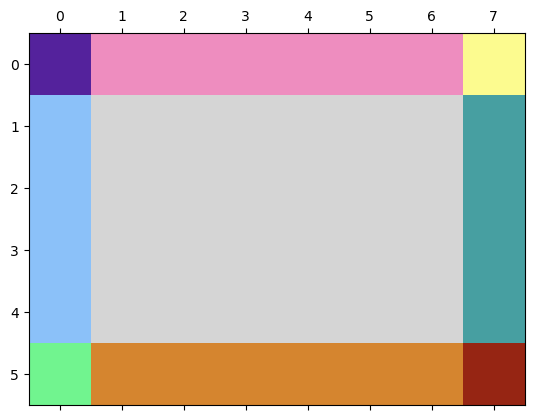

In [12]:
cmap = colors.ListedColormap(custom_colors)
plt.matshow(room, cmap=cmap)
plt.savefig("figures/empty_rectangular_room_layout.pdf")

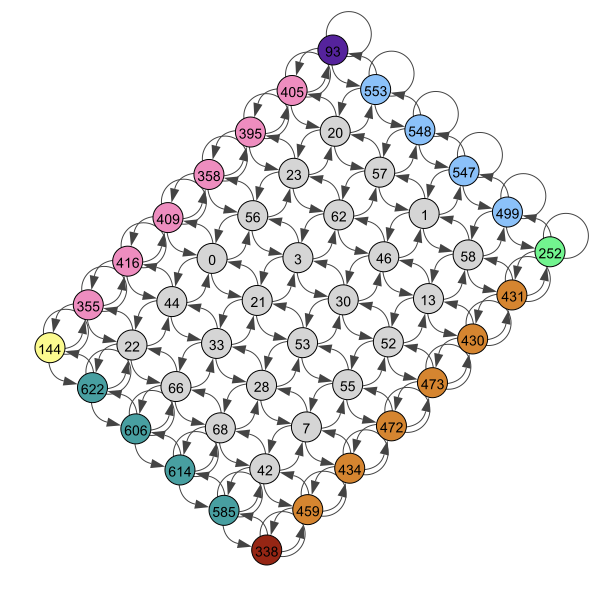

In [13]:
graph = plot_graph(
    chmm, x, a, output_file="figures/empty_rectangular_room_graph.pdf", cmap=cmap, vertex_size=30
)
graph


In [14]:
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=0.1)

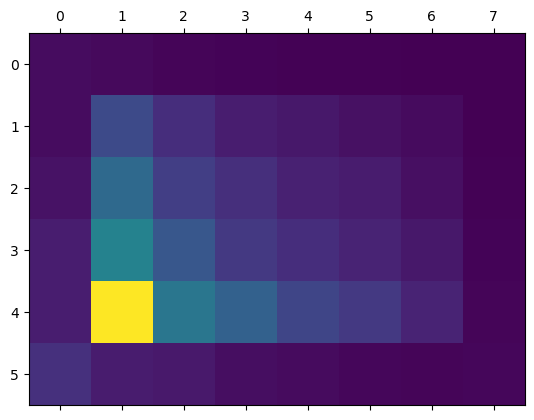

In [15]:
clone = 58
plt.matshow(place_field(mess_fwd, rc, clone))
plt.savefig("figures/empty_rectangular_room_place_field.pdf")

# 5x5 mazes

In [16]:
room = np.random.permutation(25).reshape(5, 5)

a, x, rc = datagen_structured_obs_room(room, length=10000)

n_clones = np.ones(25, dtype=np.int64) * 10

name = 'intro-5x5_maze_room'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)
else:
    chmm = CHMM(n_clones=n_clones, pseudocount=1e-2, x=x, a=a, seed=4)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training  
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object


In [17]:
# refine learning
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

  2%|▏         | 2/100 [00:00<00:03, 31.32it/s, train_bps=0.000797]


[np.float32(0.036278777), np.float32(0.0007965784), np.float32(0.0007965784)]

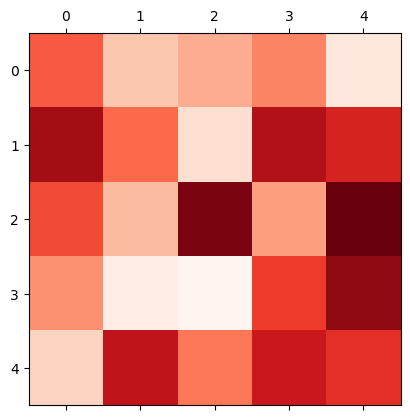

In [18]:
plt.matshow(room, cmap="Reds")
plt.savefig("figures/square_room_layout.pdf")

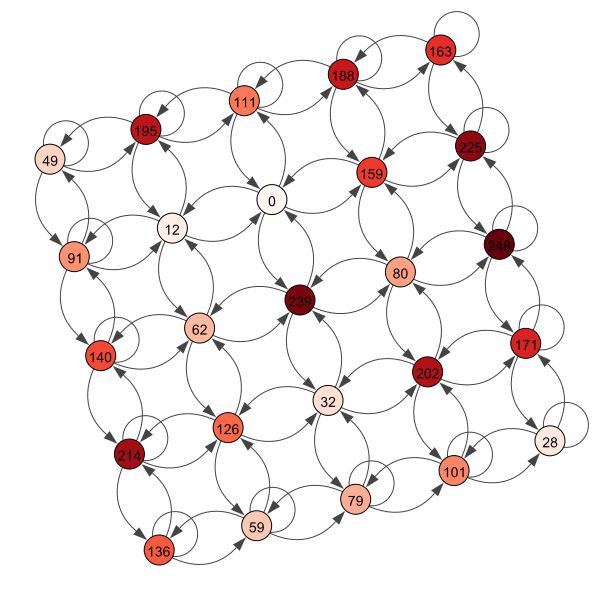

In [19]:
graph = plot_graph(
    chmm, x, a, output_file="figures/square_room_graph.pdf", cmap=cm.Reds
)
graph


In [20]:
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=0.1)

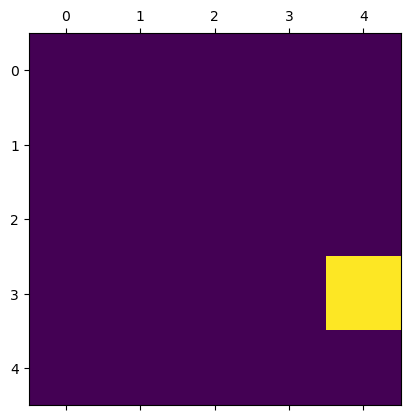

In [21]:
clone = 75
plt.matshow(place_field(mess_fwd, rc, clone))
plt.savefig("figures/square_room_place_field.pdf")

# Two Rooms Stitched Together

In [22]:
room1 = np.array(
    [
        [12, 4, 0, 1, 13, 2],
        [7, 3, 12, 11, 0, 10],
        [5, 12, 14, 12, 9, 4],
        [5, 0, 14, 7, 4, 8],
        [4, 10, 7, 2, 13, 1],
        [3, 14, 8, 3, 12, 11],
        [1, 1, 5, 12, 14, 12],
        [5, 9, 3, 0, 14, 7],
    ]
)

room2 = np.array(
    [
        [3, 12, 11, 4, 11, 11],
        [12, 14, 12, 11, 9, 1],
        [0, 14, 7, 2, 4, 9],
        [0, 0, 9, 8, 2, 11],
        [8, 13, 8, 6, 9, 2],
        [0, 5, 4, 13, 2, 14],
        [14, 4, 13, 7, 9, 14],
        [11, 1, 3, 13, 3, 0],
    ]
)

H, W = room1.shape

no_left = [(r, 0) for r in range(H)]
no_right = [(r, W-1) for r in range(H)]
no_up = [(0, c) for c in range(W)]
no_down = [(H-1, c) for c in range(W)]

a1, x1, rc1 = datagen_structured_obs_room(room1, None, None, no_left, no_right, no_up, no_down, length=50000)
a2, x2, rc2 = datagen_structured_obs_room(room2, None, None, no_left, no_right, no_up, no_down, length=50000)

x = np.hstack((0, x1 + 1, 0, x2 + 1))
a = np.hstack((4, a1[:-1], 4, 4, a2))

n_emissions = x.max() + 1

n_clones = 20 * np.ones(n_emissions, int)
n_clones[0] = 1

name = 'intro-two_rooms'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)

else:
    chmm = CHMM(n_clones=n_clones, pseudocount=2e-2, x=x, a=a, seed=19)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object


In [23]:
# refine learning
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)
bps = chmm.bps(x, a)
states = chmm.decode(x, a)[1]
n_states = len(np.unique(states))
print("n_states: {} (88 for perfect recovery), bps: {}".format(n_states, bps))


  2%|▏         | 2/100 [00:00<00:43,  2.23it/s, train_bps=0.000102]


n_states: 88 (88 for perfect recovery), bps: [ 8.23362  1.      -0.      ... -0.      -0.      -0.     ]


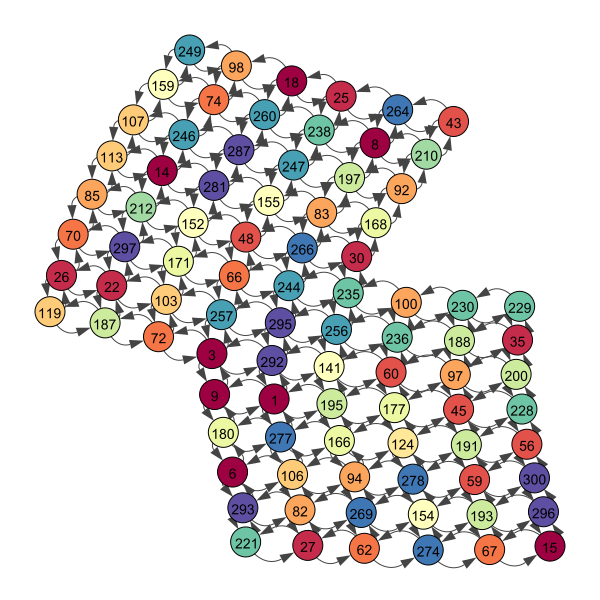

In [24]:
graph = plot_graph(chmm, x, a, output_file="figures/stitched_rooms.pdf", multiple_episodes=True)
graph


In [25]:
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=0.1)

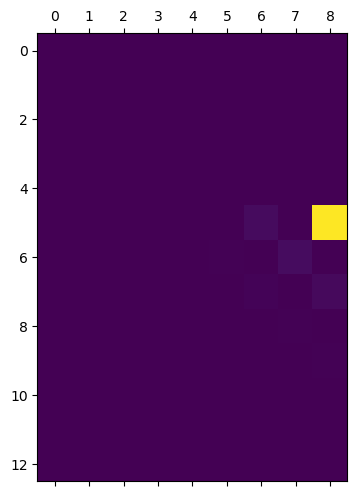

In [26]:
clone = 229
rc = np.vstack(((0, 8), rc1, (0, 8), rc2 + (5, 3)))
pf = place_field(mess_fwd, rc, clone)
pf[0, 8] = 0.0
plt.matshow(pf)
plt.savefig("figures/stitched_rooms_place_field.pdf")

## Three pentagonal cliques

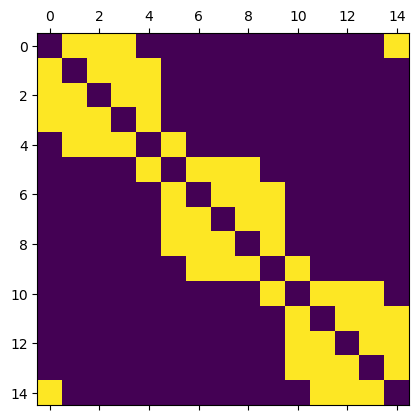

In [27]:
T = np.zeros((15, 15))
# Connect cliques
for i in range(0, 4 + 1):
    for j in range(0, 4 + 1):
        if i != j:
            T[i, j] = 1.0
for i in range(5, 9 + 1):
    for j in range(5, 9 + 1):
        if i != j:
            T[i, j] = 1.0
for i in range(10, 14 + 1):
    for j in range(10, 14 + 1):
        if i != j:
            T[i, j] = 1.0
# Disconnect in clique connector nodes
T[0, 4] = 0.0
T[4, 0] = 0.0
T[5, 9] = 0.0
T[9, 5] = 0.0
T[10, 14] = 0.0
T[14, 10] = 0.0
# Connect cross clique connector nodes
T[4, 5] = 1.0
T[5, 4] = 1.0
T[9, 10] = 1.0
T[10, 9] = 1.0
T[14, 0] = 1.0
T[0, 14] = 1.0
plt.matshow(T)

# Draw data
states = [0]
for _ in range(10000):
    prev_state = states[-1]

    possible_next_states = np.where(T[prev_state, :])[0]
    next_state = np.random.choice(possible_next_states)
    states.append(next_state)
states = np.array(states)

state_to_obs = (
    np.array([1, 2, 3, 4, 5, 6, 1, 4, 5, 2, 8, 2, 3, 5, 7], dtype=int) - 1
)  # Aliasing version

# Create observation data
x = state_to_obs[states]
a = np.zeros(len(x), dtype=int)

n_clones = np.ones(8, dtype=np.int64) * 5

name = 'intro-pentagonal_cliques'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)

else:
    chmm = CHMM(n_clones=n_clones, pseudocount=1.0, x=x, a=a)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object



In [28]:
# refine learning
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)
states = chmm.decode(x, a)[1]
n_states = len(np.unique(states))
n_states


  3%|▎         | 3/100 [00:00<00:22,  4.38it/s, train_bps=1.99]


15

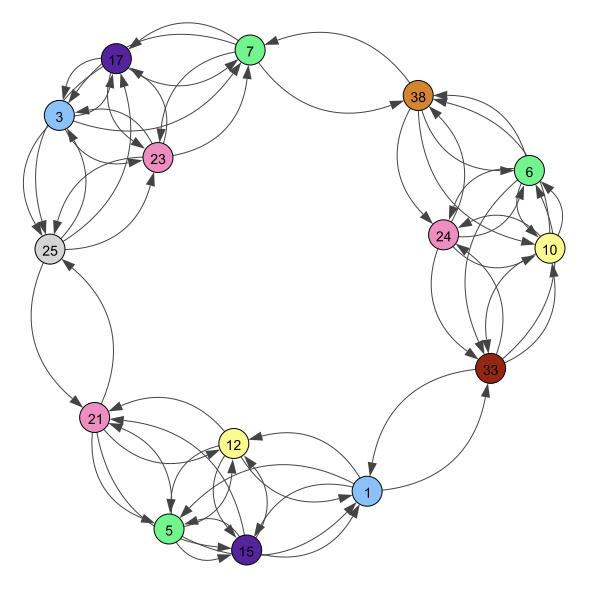

In [29]:
cmap = colors.ListedColormap(custom_colors[[7, 3, 2, 1, 5, 0, 4, 6]])
graph = plot_graph(chmm, x, a, output_file="figures/pentagonal_cliques.pdf", cmap=cmap)
graph
